## Time Series Analysis and Forecasting of Superstore Sales

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.

Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. We will demonstrate different approaches for forecasting retail sales time series. Let’s get started!

In [1]:
#Import of relevant libraries

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
#Display all columns of the data frame
pd.set_option("display.max_columns", None)

In [3]:
#Read the file
df = pd.read_csv("Superstore 2023.csv")

In [4]:
#Display the first two rows of the data
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2020-152156,08/11/2022 00:00:00,11/11/2020,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2020-152156,08/11/2022 00:00:00,11/11/2020,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [5]:
#Show the internal make up of the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          9994 non-null   int64  
 1   Order ID        9994 non-null   object 
 2   Order Date      9994 non-null   object 
 3   Ship Date       9994 non-null   object 
 4   Ship Mode       9994 non-null   object 
 5   Customer ID     9994 non-null   object 
 6   Customer Name   9994 non-null   object 
 7   Segment         9994 non-null   object 
 8   Country/Region  9994 non-null   object 
 9   City            9994 non-null   object 
 10  State           9994 non-null   object 
 11  Postal Code     9983 non-null   float64
 12  Region          9994 non-null   object 
 13  Product ID      9994 non-null   object 
 14  Category        9994 non-null   object 
 15  Sub-Category    9994 non-null   object 
 16  Product Name    9994 non-null   object 
 17  Sales           9994 non-null   f

In [6]:
# Ensure the 'Order Date' is in datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

In [7]:
#Extract the Technology values of the data frame for analysis
technology = df.loc[df['Category'] == 'Technology']

In [8]:
#Find the lowest or earliest date of order
technology['Order Date'].min()

Timestamp('2020-01-06 00:00:00')

In [9]:
#Find the latest date of order
technology['Order Date'].max()

Timestamp('2023-12-30 00:00:00')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [10]:
# Define a list of columns that are not needed for the current analysis or operations.
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country/Region', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

# Drop the specified columns from the 'technology' DataFrame, removing them permanently (inplace=True).
technology.drop(cols, axis=1, inplace=True)

# Sort the remaining data in the 'technology' DataFrame by 'Order Date' in ascending order.
technology = technology.sort_values('Order Date')

In [11]:
#Find sum of null values in the data frame
technology.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [12]:
#Group the Sales by Order date
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()

In [13]:
#Show first five rows of the data frame
technology.head()

,Order Date,Sales
0,2020-01-06,1147.94
1,2020-01-09,31.20
2,2020-01-13,646.74
3,2020-01-15,149.95
4,2020-01-16,124.20


## Indexing with time series data

In [14]:
#Reset the index in the data frame to the Order Date column
technology = technology.set_index('Order Date')
technology.index

DatetimeIndex(['2020-01-06', '2020-01-09', '2020-01-13', '2020-01-15',
               '2020-01-16', '2020-01-20', '2020-01-26', '2020-02-01',
               '2020-02-02', '2020-02-06',
               ...
               '2023-12-18', '2023-12-21', '2023-12-22', '2023-12-23',
               '2023-12-24', '2023-12-25', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=824, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

#### Why resample the data

1. Time series data at a higher frequency, such as daily or weekly, can contain a lot of noise due to short-term fluctuations, holidays, or random events. This noise can make it harder to identify long-term trends and patterns.

2. Resampling the data to monthly or quarterly averages can smooth out these short-term fluctuations, making it easier to discern underlying trends and seasonal patterns, which are crucial for accurate forecasting.

In [15]:
#Resample the data
y = technology['Sales'].resample('MS').mean()

In [16]:
#Show the mean sales for each month
y['2023':]

Order Date
2023-01-01    1195.218071
2023-02-01     430.501714
2023-03-01    1392.859250
2023-04-01     825.559133
2023-05-01     678.329400
2023-06-01     853.055000
2023-07-01    1054.996636
2023-08-01     978.842333
2023-09-01    1077.704120
2023-10-01    1493.439227
2023-11-01    1996.750920
2023-12-01     955.865652
Freq: MS, Name: Sales, dtype: float64

## Visualizing furniture sales time series data

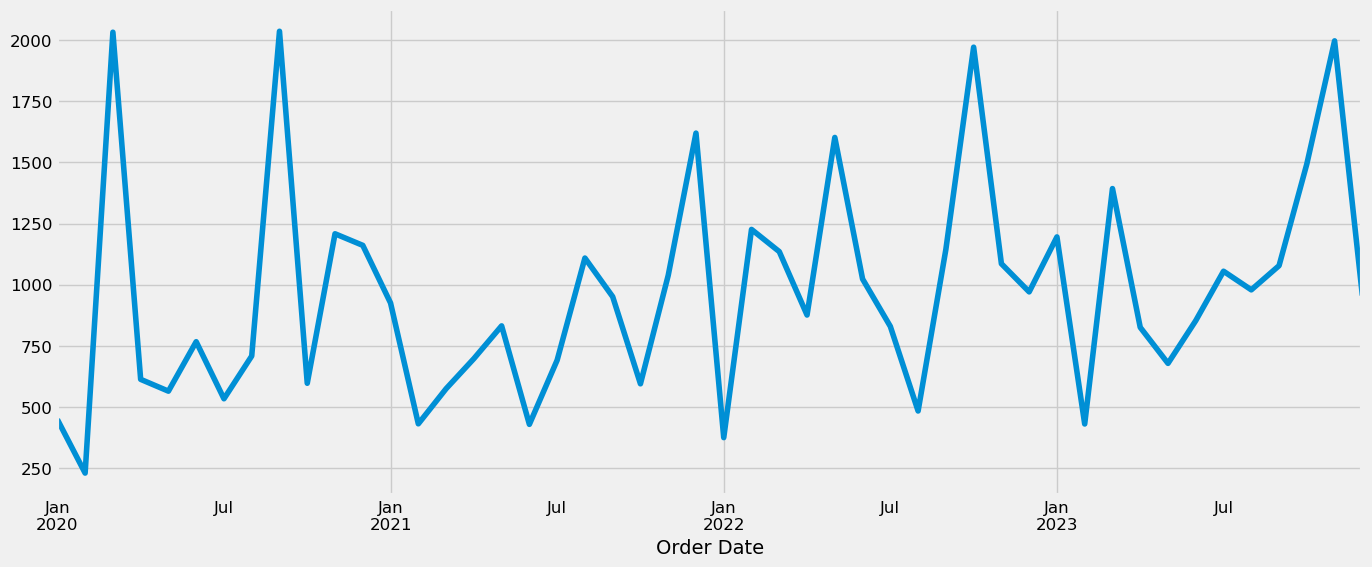

In [45]:
#Ploting Sales - dependent variable
y.plot(figsize=(15, 6))
plt.show()

The graph represents furniture sales data over a period from January 2020 to July 2023. Here are some key observations:

#### Sales Fluctuations

The line graph shows fluctuations in furniture sales over time. There are several peaks and troughs, indicating variability in sales volume.

#### Seasonal Trends

Notably, there are sharp increases and decreases at regular intervals. This suggests possible seasonal trends or other cyclical factors affecting furniture sales.

#### Yearly Patterns

Each year follows a similar pattern, with sales rising in the first half (January to July) and declining in the second half (July to December).

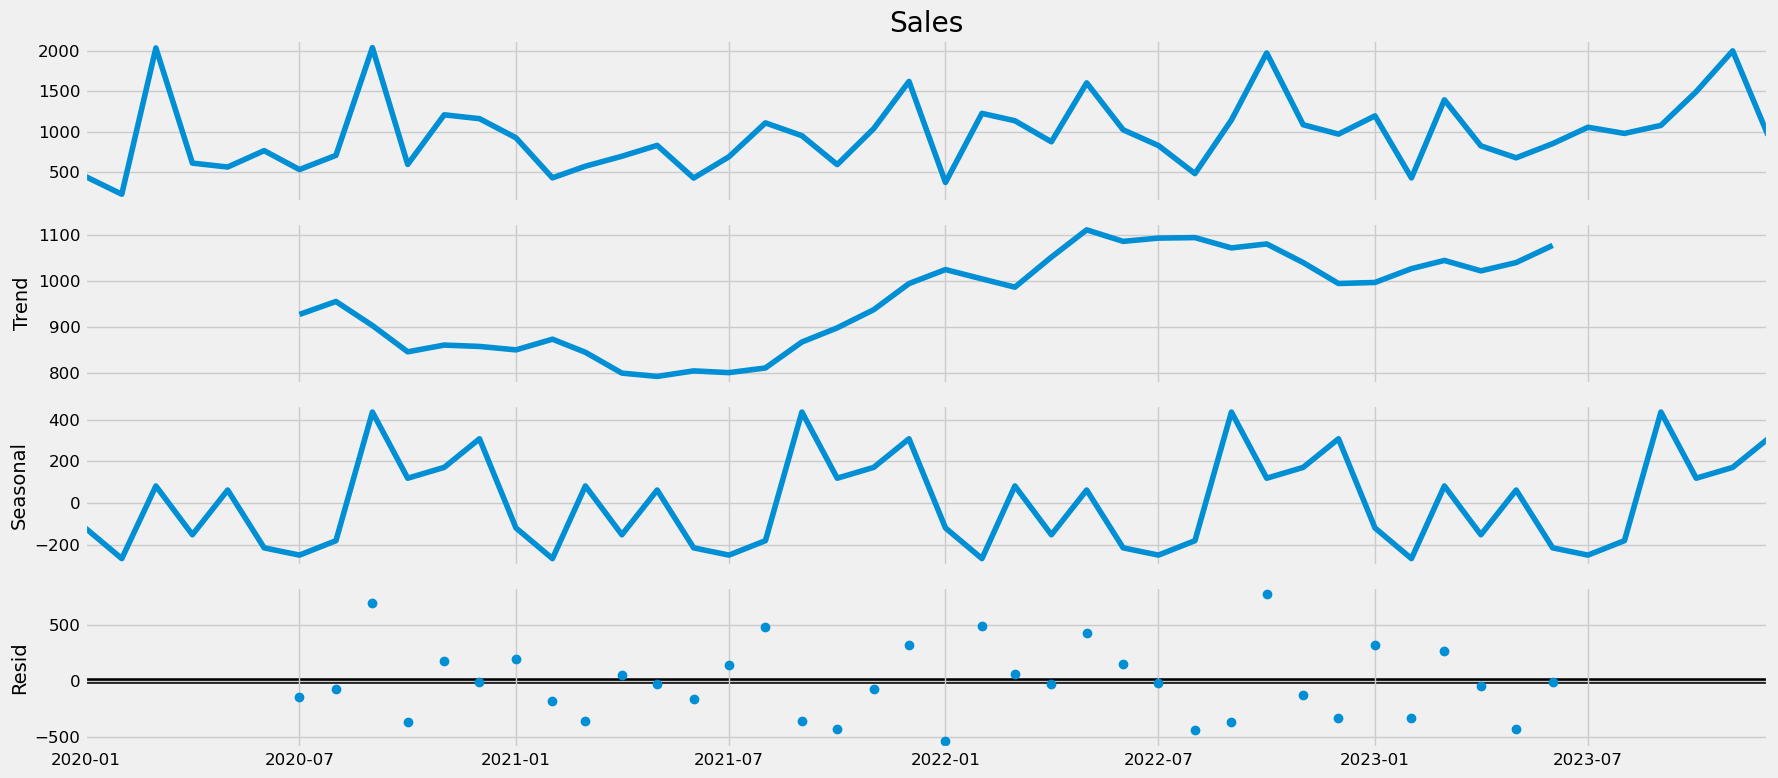

In [18]:
# Importing the rcParams module from pylab to customize the default size of plots
from pylab import rcParams

# Setting the default figure size for plots to 18 inches wide and 8 inches tall
rcParams['figure.figsize'] = 18, 8

# Performing seasonal decomposition on the time series data 'y' using an additive model
decomposition = sm.tsa.seasonal_decompose(y, model='additive')

# Plotting the components (trend, seasonal, and residual) of the decomposed time series
fig = decomposition.plot()

# Displaying the plot with the decomposed components
plt.show()

The graph above is a time series decomposition plot. It breaks down the observed sales data into different components to better understand underlying patterns and anomalies. 
Here’s what each panel represents:

##### Observed Sales Data (Top Panel):

This panel shows the original sales data over time. Fluctuations suggest both trend and seasonal patterns.
The data appears to have regular peaks and troughs.

##### Trend Component (Second Panel):
The second panel displays the trend component of the sales data.
The trend represents the general direction or pattern in the data over time, excluding seasonal effects.

##### Seasonal Component (Third Panel):
The third panel depicts the seasonal component.
It highlights regular patterns that repeat over a specific period (e.g., weekly, monthly).

##### Residual Component (Bottom Panel):
The bottom panel shows the residual component.
Residuals represent irregularities or random noise left in the data after removing trend and seasonal effects.

In [19]:
# Define the range for the parameters p, d, and q (each taking values 0 or 1)
p = d = q = range(0, 2)

# Generate all combinations of p, d, and q using Cartesian product (for non-seasonal ARIMA parameters)
pdq = list(itertools.product(p, d, q))

# Generate all combinations of p, d, and q for seasonal ARIMA parameters with a seasonal period of 12 (monthly data)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Print examples of parameter combinations for the Seasonal ARIMA (SARIMAX) model
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))  # Example 1: Combine the 2nd non-seasonal and seasonal parameter set
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))  # Example 2: Combine the 2nd non-seasonal and 3rd seasonal parameter set
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))  # Example 3: Combine the 3rd non-seasonal and 4th seasonal parameter set
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))  # Example 4: Combine the 3rd non-seasonal and 5th seasonal parameter set


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [20]:
# Suppress only convergence warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

import warnings

In [21]:
# Loop over each combination of non-seasonal parameters (p, d, q)
for param in pdq:
    # Loop over each combination of seasonal parameters (P, D, Q, m)
    for param_seasonal in seasonal_pdq:
        try:
            # Initialize the SARIMAX model with the current set of parameters
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,              # Non-seasonal parameters (p, d, q)
                                            seasonal_order=param_seasonal,  # Seasonal parameters (P, D, Q, m)
                                            enforce_stationarity=False,   # Disable stationarity enforcement
                                            enforce_invertibility=False)  # Disable invertibility enforcement

            # Fit the SARIMAX model to the data
            results = mod.fit()

            # Print the parameters and the corresponding AIC value for model evaluation
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        
        # If an error occurs (e.g., model fails to converge), continue to the next set of parameters
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:791.4891765009955
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1537.9367845648437
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:549.0156237882129
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:356.4725519399046
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:564.1031529698099
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:542.9210079120122
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:372.6612068172691
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:357.8845253700008
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:750.8969484750892
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2768.21530459045
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:535.0489454747241
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:341.1892359669994
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:566.0827904028456
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:526.5322595781574
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:373.8760065868629
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:342.63073634199986
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:729.3478530285049
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1624.5622505304073
ARIMA(0,

In [22]:
# Example of a simpler SARIMAX model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),  # Simplified order
                                seasonal_order=(0, 1, 1, 12),  # Simplified seasonal order
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1726      0.286     -0.604      0.546      -0.732       0.387
ma.L1         -1.0000   2664.595     -0.000      1.000   -5223.510    5221.510
ma.S.L12      -1.0000   2664.693     -0.000      1.000   -5223.703    5221.702
sigma2      1.631e+05      0.010   1.59e+07      0.000    1.63e+05    1.63e+05


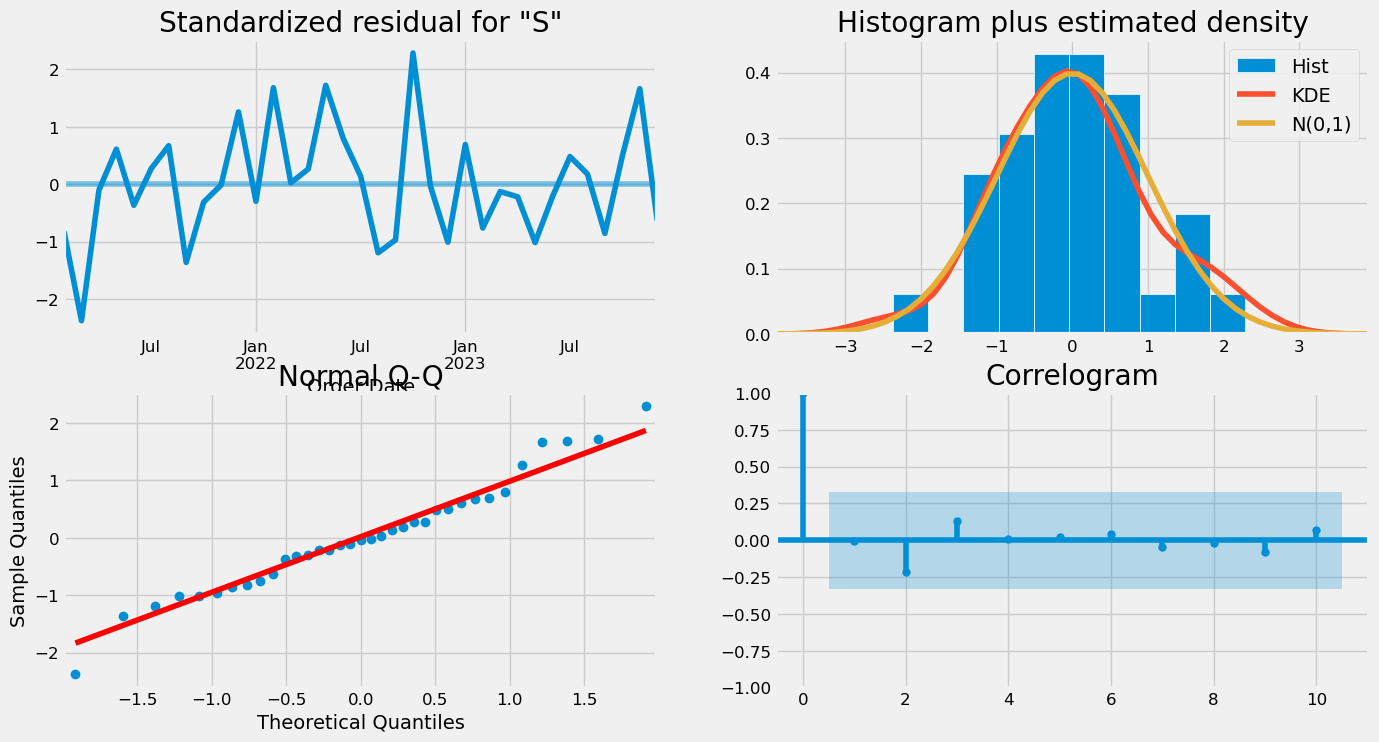

In [23]:
#Plot diagnostics
results.plot_diagnostics(figsize=(15, 8))
plt.show()

#### A brief interpretation of each plot:

##### Standardized Residuals (Top Left):

This plot shows the residuals over time. The residuals fluctuate around zero, indicating that the model captures the data well. However, the variance seems to be somewhat consistent, which is a good sign of homoscedasticity.

##### Histogram plus Estimated Density (Top Right):

The histogram of the residuals is overlaid with a Kernel Density Estimate (KDE) and a standard normal distribution curve (N(0,1)). The residuals roughly follow a normal distribution, but there may be slight deviations, particularly with slightly heavier tails. This indicates that the residuals are close to normal, which is a positive sign.

##### Normal Q-Q Plot (Bottom Left):

This plot compares the quantiles of the residuals with the quantiles of a standard normal distribution. The points mostly lie along the red line, suggesting that the residuals are approximately normally distributed. Deviations at the ends suggest that there might be some minor outliers or slight skewness.

##### Correlogram (ACF Plot, Bottom Right):

The correlogram displays the autocorrelation function (ACF) of the residuals. The lags are mostly within the confidence intervals (shaded region), indicating that there is no significant autocorrelation in the residuals. This suggests that the model has adequately captured the time series structure and there are no leftover patterns.


The diagnostic plots suggest that the model fits the data reasonably well, with residuals that are approximately normally distributed and uncorrelated. There are no major violations of the model assumptions, which supports the validity of the model for forecasting.

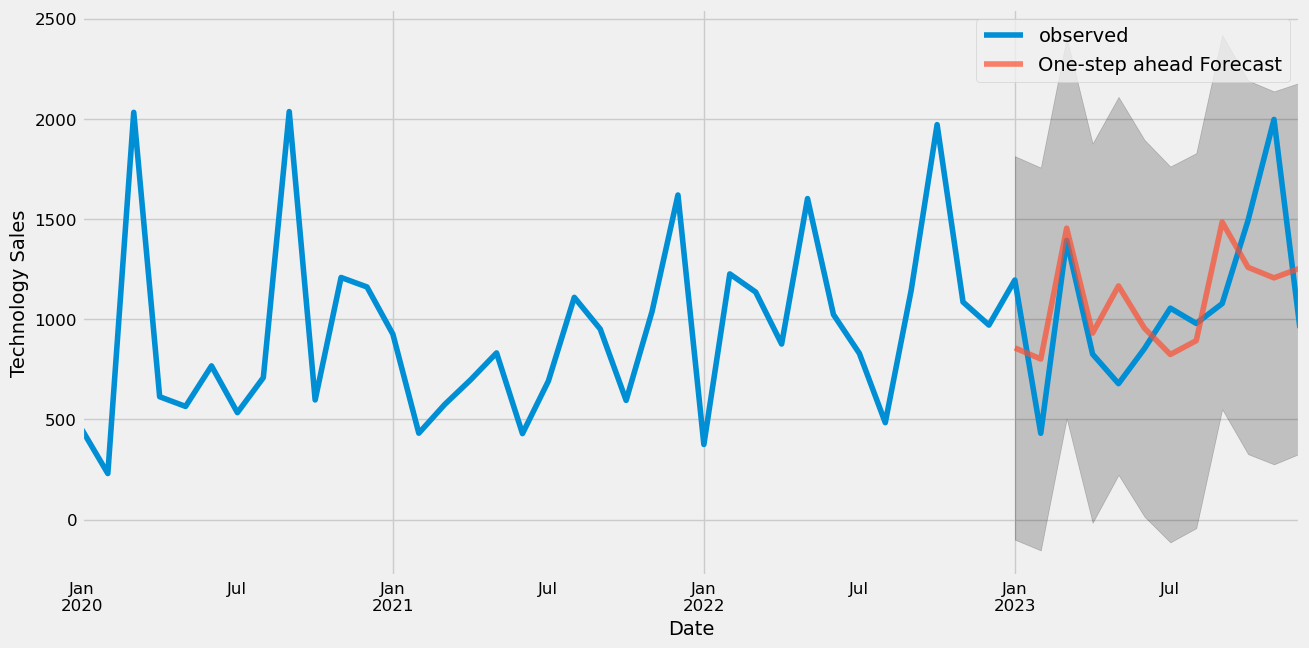

In [24]:
# Get the prediction results from the model starting from January 1, 2023. 
# 'dynamic=False' means it will not use dynamic forecasts (i.e., forecasts will be based on the model's last forecast).
pred = results.get_prediction(start=pd.to_datetime('2023-01-01'), dynamic=False)

# Obtain the confidence intervals for the predictions.
pred_ci = pred.conf_int()

# Plot the observed data from the year 2020 onwards.
ax = y['2020':].plot(label='observed')

# Plot the one-step ahead forecasted values on the same axis.
# 'alpha=.7' adjusts the transparency of the forecast line, 'figsize=(14, 7)' sets the size of the plot.
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

# Add a shaded area to represent the confidence intervals of the forecast.
# 'color' sets the fill color, 'alpha=.2' adjusts the transparency of the shaded area.
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

# Label the x-axis as 'Date'.
ax.set_xlabel('Date')

# Label the y-axis as 'Technology Sales'.
ax.set_ylabel('Technology Sales')

# Add a legend to differentiate between the observed data and the forecast.
plt.legend()

# Display the plot.
plt.show()

The graph above shows the technology sales over time. The blue line represents the actual sales, while the red line represents the one-step ahead forecast. The shaded area represents the confidence interval for the forecast.

The graph shows that the technology sales have been fluctuating over the past few years. There have been periods of growth and decline. The forecast suggests that sales are expected to continue to fluctuate in the future. The confidence interval shows that there is a range of possible outcomes for the forecast.

Overall, the graph provides a visual representation of the technology sales and the forecast for the future. It can be used to understand the trends in the market and to make informed decisions about business strategy.

In [25]:
# Extract the forecasted values from the prediction object
y_forecasted = pred.predicted_mean

# Extract the true values from the actual dataset starting from January 1, 2023
y_truth = y['2023-01-01':]

# Calculate the Mean Squared Error (MSE) between the forecasted values and the true values
# MSE is computed by squaring the difference between forecasted and true values,
# then taking the mean of these squared differences
mse = ((y_forecasted - y_truth) ** 2).mean()

# Print the Mean Squared Error, rounded to 2 decimal places
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 125896.09


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 354.82 of the real sales. Our Technology daily sales range from around 250 to over 2000. In my opinion, this is a pretty good model so far.

In [26]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 354.82


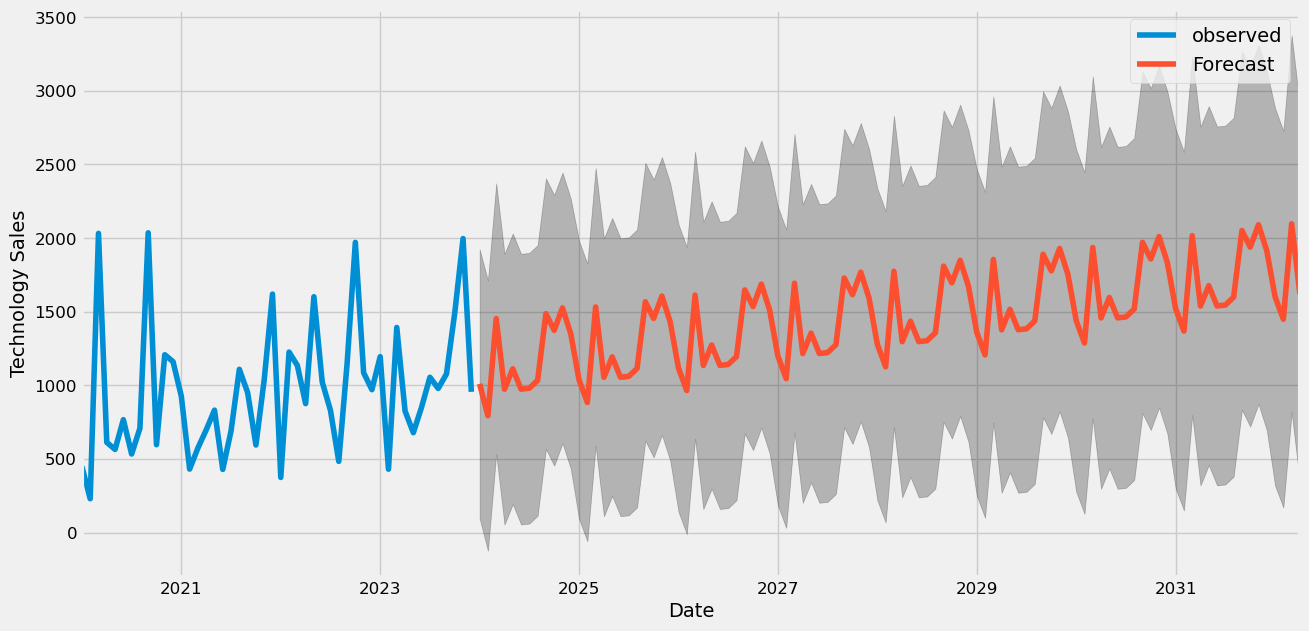

In [27]:
# Generate forecast for the next 100 steps
pred_uc = results.get_forecast(steps=100)

# Calculate the confidence intervals for the forecast
pred_ci = pred_uc.conf_int()

# Plot the observed data
ax = y.plot(label='observed', figsize=(14, 7))

# Plot the forecasted mean values
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

# Fill the area between the confidence intervals with a shaded region
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],  # Lower bound of the confidence interval
                pred_ci.iloc[:, 1],  # Upper bound of the confidence interval
                color='k',           # Color of the shaded area
                alpha=.25)           # Transparency of the shaded area

# Set the x-axis label
ax.set_xlabel('Date')

# Set the y-axis label
ax.set_ylabel('Technology Sales')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


The graph above displays a time series plot of technology sales with observed values in blue and forecasted values in red. 

Let's explain the graph.

##### Observed Data (Blue Line):

The blue line represents the historical sales data for technology products from 2020 to early 2024. There is noticeable seasonality and variability in sales over this period, with peaks and troughs occurring at regular intervals.

##### Forecasted Data (Red Line):

The red line indicates the forecasted sales for technology products from 2024 onwards. The forecast suggests a continuation of the seasonal pattern observed in the historical data, with regular fluctuations in sales.

##### Confidence Interval (Shaded Area):

The shaded area around the forecast represents the confidence interval, indicating the range within which the true future values are likely to fall. The wider the shaded area, the greater the uncertainty in the forecast. As time progresses, the confidence interval widens, reflecting increasing uncertainty in long-term predictions.

The graph indicates that the forecast model has successfully captured the seasonal patterns in the sales data, but as expected, the uncertainty increases with time. The forecasted values are expected to follow a similar seasonal pattern, with peaks and troughs, though the exact values may vary within the confidence interval.

In [28]:
#Extracting Sales Values for Technology and Furniture for a comparative analysis
technology = df.loc[df['Category'] == 'Technology']
furniture = df.loc[df['Category'] == 'Furniture']

In [29]:
technology.shape, furniture.shape

((1847, 21), (2121, 21))

In [30]:
# Define a list of columns to drop from both the technology and furniture dataframes
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country/Region', 
        'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

# Drop the specified columns from the 'technology' dataframe
technology.drop(cols, axis=1, inplace=True)

# Drop the specified columns from the 'furniture' dataframe
furniture.drop(cols, axis=1, inplace=True)

# Sort the 'technology' dataframe by 'Order Date' in ascending order
technology = technology.sort_values('Order Date')

# Sort the 'furniture' dataframe by 'Order Date' in ascending order
furniture = furniture.sort_values('Order Date')

# Group the 'technology' dataframe by 'Order Date', sum the 'Sales' for each date, and reset the index
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()

# Group the 'furniture' dataframe by 'Order Date', sum the 'Sales' for each date, and reset the index
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()


In [31]:
technology.head()

,Order Date,Sales
0,2020-01-06,1147.94
1,2020-01-09,31.20
2,2020-01-13,646.74
3,2020-01-15,149.95
4,2020-01-16,124.20


In [32]:
furniture.head()

,Order Date,Sales
0,2020-01-06,2573.820
1,2020-01-07,76.728
2,2020-01-10,51.940
3,2020-01-11,9.940
4,2020-01-13,879.939


In [33]:
# Set 'Order Date' as the index for both technology and furniture dataframes
technology = technology.set_index('Order Date')
furniture = furniture.set_index('Order Date')

# Resample the technology sales data to monthly frequency ('MS' stands for month start) and calculate the mean sales per month
y_technology = technology['Sales'].resample('MS').mean()

# Resample the furniture sales data to monthly frequency and calculate the mean sales per month
y_furniture = furniture['Sales'].resample('MS').mean()

# Convert the resampled technology sales data back into a dataframe
technology = pd.DataFrame({'Order Date': y_technology.index, 'Sales': y_technology.values})

# Convert the resampled furniture sales data back into a dataframe
furniture = pd.DataFrame({'Order Date': y_furniture.index, 'Sales': y_furniture.values})

# Merge the technology and furniture dataframes on 'Order Date', keeping only the common dates
store = technology.merge(furniture, how='inner', on='Order Date')

# Rename the columns to reflect the type of sales data they represent
store.rename(columns={'Sales_x': 'technology_sales', 'Sales_y': 'furniture_sales'}, inplace=True)

# Display the first few rows of the merged dataframe
store.head()

,Order Date,technology_sales,furniture_sales
0,2020-01-01,449.041429,480.194231
1,2020-02-01,229.787143,367.931600
2,2020-03-01,2031.948375,857.291529
3,2020-04-01,613.028933,567.488357
4,2020-05-01,564.698588,432.049188


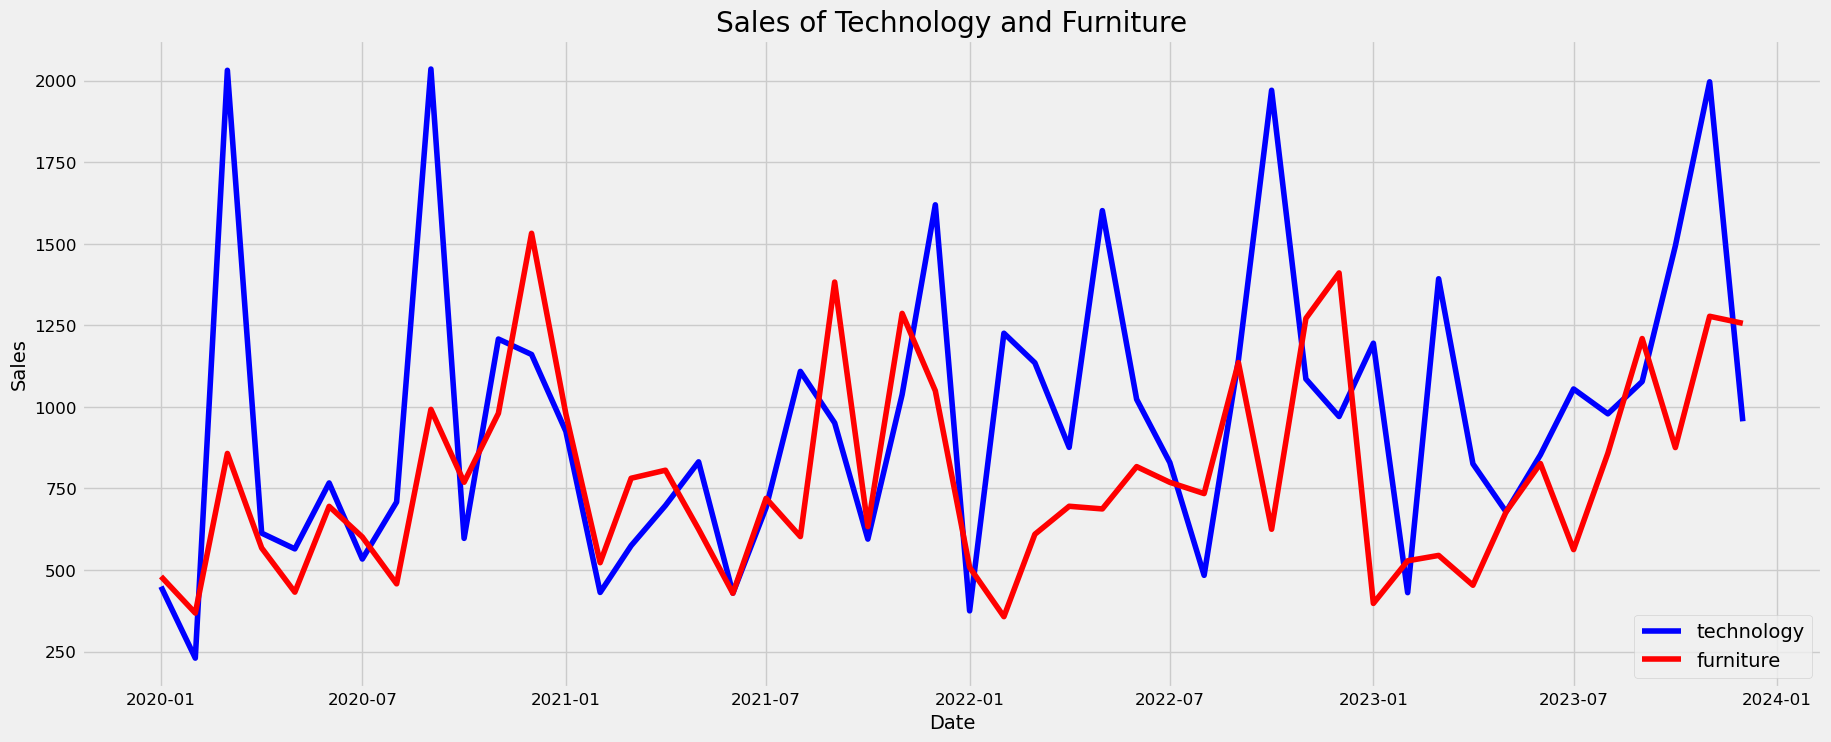

In [34]:
#Plot of Technology and Furniture Sales over time
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['technology_sales'], 'b-', label = 'technology')
plt.plot(store['Order Date'], store['furniture_sales'], 'r-', label = 'furniture')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Technology and Furniture')
plt.legend();

The graph above illustrates the sales trends for Technology (in blue) and Furniture (in red) over a period from early 2020 to the end of 2023.

#### Key Observations:

Volatility: Both categories exhibit significant fluctuations in sales over time, with notable peaks and troughs. Technology sales appear more volatile with higher peaks, especially at the start and end of the period.

Seasonal Patterns: There are recurring peaks in sales, particularly around the same time each year, which might indicate seasonal trends or events that drive sales increases during specific periods.

#### Comparison of Categories:

Technology generally outperforms Furniture in terms of sales volume, with several instances where Technology sales sharply peak while Furniture sales remain relatively lower.

Furniture Sales show some periods of alignment with Technology sales, especially during the upward trends, suggesting that sales in these categories might be influenced by similar factors during certain periods.

Overall, the graph indicates that Technology sales are more dynamic and prone to significant spikes compared to Furniture, which has a relatively more stable and consistent trend over the observed period.

In [35]:
# Find the index of the first occurrence where 'furniture_sales' is greater than 'technology_sales'
first_index = np.min(list(np.where(store['furniture_sales'] > store['technology_sales'])[0]))

# Retrieve the 'Order Date' corresponding to the identified index
first_date = store.loc[first_index, 'Order Date']

# Print the date when furniture sales first exceeded technology sales
print("Furniture for the first time produced higher sales than technology in {}.".format(first_date.date()))

Furniture for the first time produced higher sales than technology in 2020-01-01.


### Modelling with Prophet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [36]:
# Import the Prophet class from the prophet module for time series forecasting
from prophet import Prophet  # Use lowercase 'prophet' for the module

# Prepare the 'technology' DataFrame for forecasting
# Rename columns to match the Prophet's expected input format
# 'Order Date' column is renamed to 'ds' (date column)
# 'Sales' column is renamed to 'y' (value column to forecast)
technology = technology.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Initialize a Prophet model with a 95% confidence interval width
technology_model = Prophet(interval_width=0.95)

# Fit the Prophet model on the 'technology' DataFrame
technology_model.fit(technology)

# Prepare the 'furniture' DataFrame for forecasting
# Rename columns to match the Prophet's expected input format
# 'Order Date' column is renamed to 'ds' (date column)
# 'Sales' column is renamed to 'y' (value column to forecast)
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Initialize a Prophet model with a 95% confidence interval width
furniture_model = Prophet(interval_width=0.95)

# Fit the Prophet model on the 'furniture' DataFrame
furniture_model.fit(furniture)


14:44:42 - cmdstanpy - INFO - Chain [1] start processing
14:44:42 - cmdstanpy - INFO - Chain [1] done processing
14:44:43 - cmdstanpy - INFO - Chain [1] start processing
14:44:43 - cmdstanpy - INFO - Chain [1] done processing


#### Create a future dataframe for technology forecasts

In [37]:
# The 'make_future_dataframe' function generates a dataframe that includes future periods.
# 'periods=36' specifies that we want to forecast for 36 months into the future.
# 'freq="MS"' indicates that the frequency is set to the start of each month.

technology_forecast = technology_model.make_future_dataframe(periods=36, freq='MS')

# Predict future values for the technology data using the previously created dataframe
# The 'predict' function generates forecasts for the future periods specified in 'technology_forecast'.
technology_forecast = technology_model.predict(technology_forecast)

# Create a future dataframe for furniture forecasts
# Similar to the technology forecasts, this dataframe includes 36 months of future periods.
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')

# Predict future values for the furniture data using the previously created dataframe
# This generates forecasts for the future periods specified in 'furniture_forecast'.
furniture_forecast = furniture_model.predict(furniture_forecast)

<Figure size 1600x600 with 0 Axes>

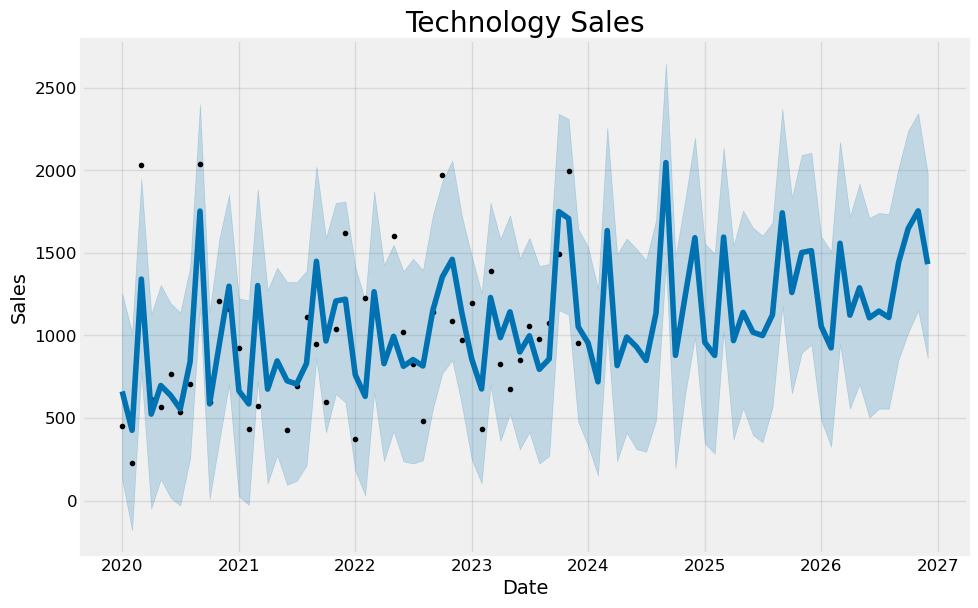

In [38]:
#Plot the Technology Sales forecast
plt.figure(figsize=(16, 6))
technology_model.plot(technology_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Technology Sales');

<Figure size 1800x600 with 0 Axes>

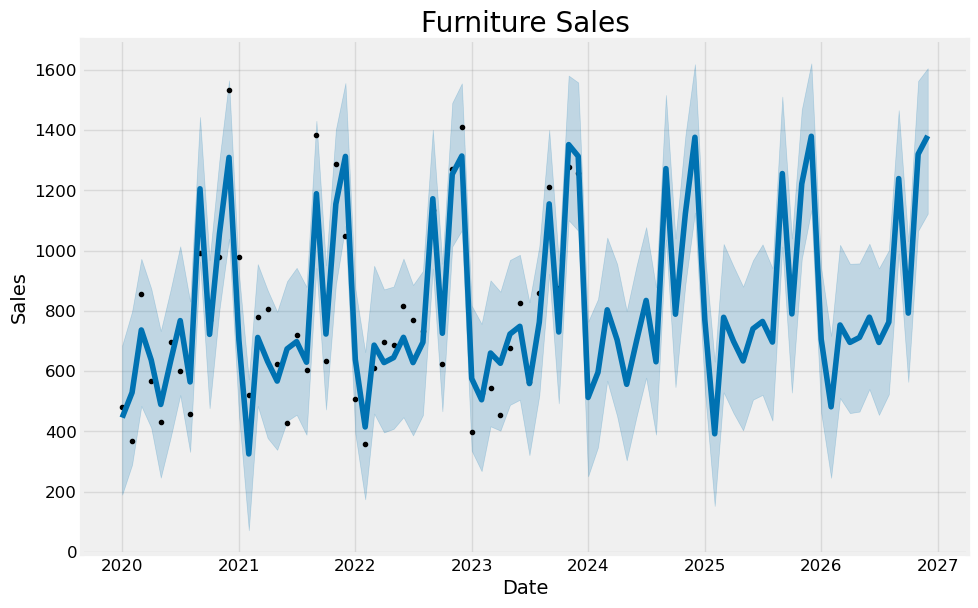

In [39]:
#Plot the Furniture Sales forecast
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

In [87]:
# Generate new column names for the technology forecast DataFrame by prefixing each column name with 'technology_'
technology_names = ['technology_%s' % column for column in technology_forecast.columns]

# Generate new column names for the furniture forecast DataFrame by prefixing each column name with 'furniture_'
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]

# Create a copy of the technology forecast DataFrame to avoid modifying the original data
merge_technology_forecast = technology_forecast.copy()

# Create a copy of the furniture forecast DataFrame to avoid modifying the original data
merge_furniture_forecast = furniture_forecast.copy()

# Rename the columns in the technology forecast DataFrame using the generated 'technology_' prefixed names
merge_technology_forecast.columns = technology_names

# Rename the columns in the furniture forecast DataFrame using the generated 'furniture_' prefixed names
merge_furniture_forecast.columns = furniture_names

# Merge the two forecast DataFrames (technology and furniture) on their respective date columns
# The merge is done using an 'inner' join, which keeps only the rows that have matching dates in both DataFrames
forecast = pd.merge(merge_technology_forecast, merge_furniture_forecast, how='inner', left_on='technology_ds', right_on='furniture_ds')

# Rename the 'technology_ds' column to 'Date' and drop the redundant 'furniture_ds' column from the merged DataFrame
forecast = forecast.rename(columns={'technology_ds': 'Date'}).drop('furniture_ds', axis=1)

# Display the first few rows of the resulting forecast DataFrame
forecast.tail()

,Date,technology_trend,technology_yhat_lower,technology_yhat_upper,technology_trend_lower,technology_trend_upper,technology_additive_terms,technology_additive_terms_lower,technology_additive_terms_upper,technology_yearly,technology_yearly_lower,technology_yearly_upper,technology_multiplicative_terms,technology_multiplicative_terms_lower,technology_multiplicative_terms_upper,technology_yhat,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yhat
79,2026-08-01,1261.803433,555.892143,1734.838013,1261.801764,1261.805260,-153.198044,-153.198044,-153.198044,-153.198044,-153.198044,-153.198044,0.0,0.0,0.0,1108.605390,899.166696,523.149108,1000.495505,899.166423,899.166978,-136.592243,-136.592243,-136.592243,-136.592243,-136.592243,-136.592243,0.0,0.0,0.0,762.574453
80,2026-09-01,1268.034988,856.191102,2016.995894,1268.033236,1268.036893,175.921491,175.921491,175.921491,175.921491,175.921491,175.921491,0.0,0.0,0.0,1443.956479,900.584856,990.462877,1465.487111,900.584571,900.585153,338.123132,338.123132,338.123132,338.123132,338.123132,338.123132,0.0,0.0,0.0,1238.707988
81,2026-10-01,1274.065524,1017.756184,2240.929824,1274.063685,1274.067516,374.151368,374.151368,374.151368,374.151368,374.151368,374.151368,0.0,0.0,0.0,1648.216892,901.957268,564.487647,1030.662991,901.956971,901.957580,-109.403299,-109.403299,-109.403299,-109.403299,-109.403299,-109.403299,0.0,0.0,0.0,792.553970
82,2026-11-01,1280.297078,1150.485305,2344.844910,1280.295145,1280.299142,473.738054,473.738054,473.738054,473.738054,473.738054,473.738054,0.0,0.0,0.0,1754.035133,903.375428,1065.677210,1562.780958,903.375117,903.375752,416.525360,416.525360,416.525360,416.525360,416.525360,416.525360,0.0,0.0,0.0,1319.900788
83,2026-12-01,1286.327615,862.971990,1979.571253,1286.325591,1286.329753,144.865818,144.865818,144.865818,144.865818,144.865818,144.865818,0.0,0.0,0.0,1431.193433,904.747841,1122.316791,1604.584190,904.747521,904.748178,475.699473,475.699473,475.699473,475.699473,475.699473,475.699473,0.0,0.0,0.0,1380.447314


In [91]:
forecast_only = forecast[["Date", "technology_yhat", "furniture_yhat"]]

In [111]:
# Technology and Furniture Forecast for 2023.
forecast_only[forecast_only["Date"].dt.year == 2023].head(3)

,Date,technology_yhat,furniture_yhat
36,2023-01-01,857.667813,575.345073
37,2023-02-01,675.477557,505.037117
38,2023-03-01,1229.545265,660.183179


In [112]:
# Technology and Furniture Forecast for 2024.
forecast_only[forecast_only["Date"].dt.year == 2024].head(3)

,Date,technology_yhat,furniture_yhat
48,2024-01-01,954.402811,512.637651
49,2024-02-01,718.907908,595.949481
50,2024-03-01,1634.652914,803.445369


In [113]:
# Technology and Furniture Forecast for 2025.
forecast_only[forecast_only["Date"].dt.year == 2025].head(3)

,Date,technology_yhat,furniture_yhat
60,2025-01-01,957.821571,770.074407
61,2025-02-01,878.743721,392.262628
62,2025-03-01,1595.314103,778.630706


In [114]:
# Technology and Furniture Forecast for 2026.
forecast_only[forecast_only["Date"].dt.year == 2026].head(3)

,Date,technology_yhat,furniture_yhat
72,2026-01-01,1054.609470,705.742526
73,2026-02-01,924.569169,481.681414
74,2026-03-01,1558.135723,753.143309


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


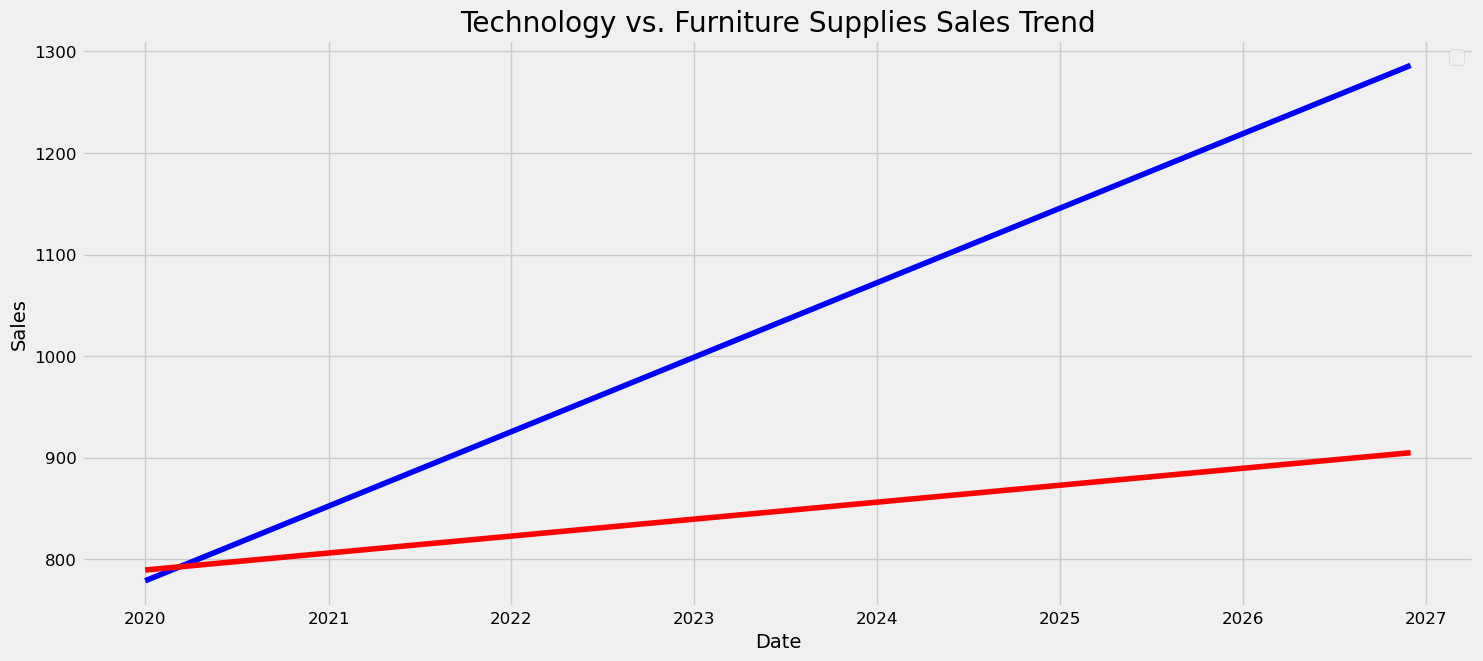

In [41]:
#Plotting Technology and Furniture Forecast Sales Trend
plt.figure(figsize=(16, 7))
plt.plot(forecast['Date'], forecast['technology_trend'], 'b-')
plt.plot(forecast['Date'], forecast['furniture_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Technology vs. Furniture Supplies Sales Trend');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


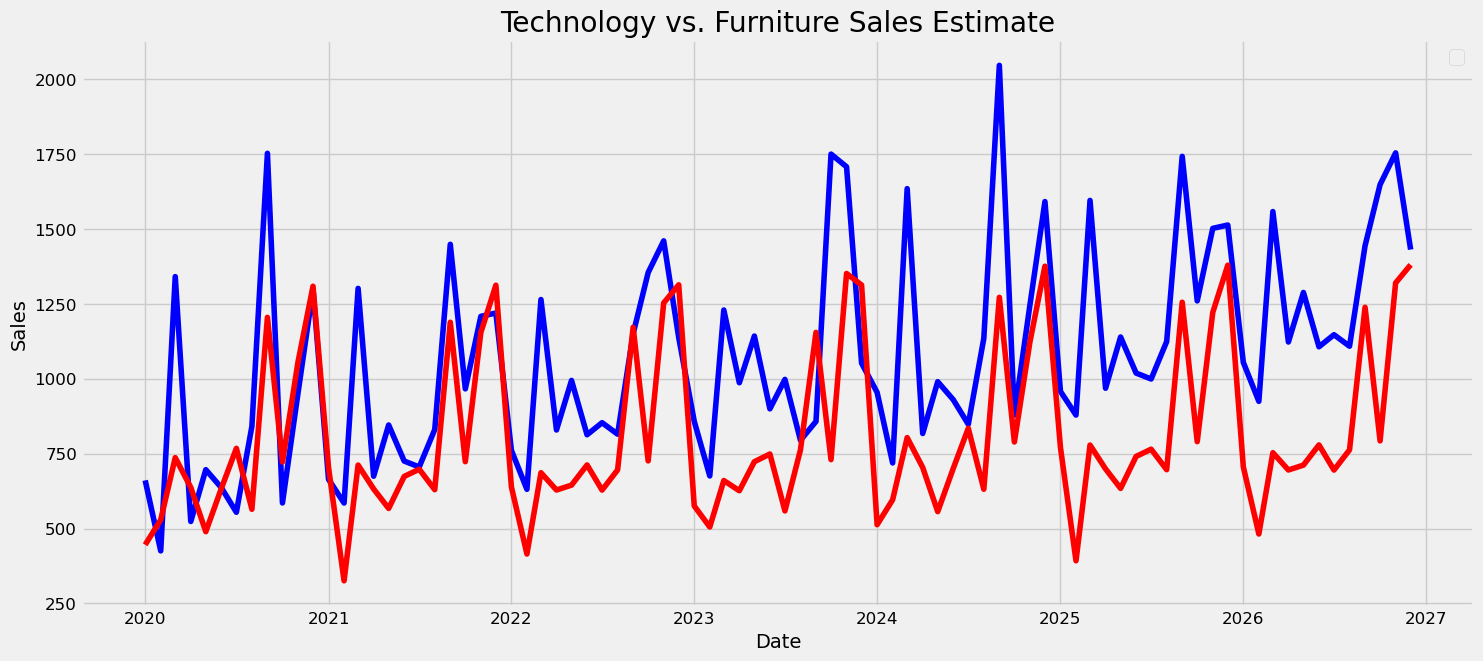

In [42]:
#Plotting Technology and Furniture Sales Estimate
plt.figure(figsize=(16, 7))
plt.plot(forecast['Date'], forecast['technology_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Technology vs. Furniture Sales Estimate');

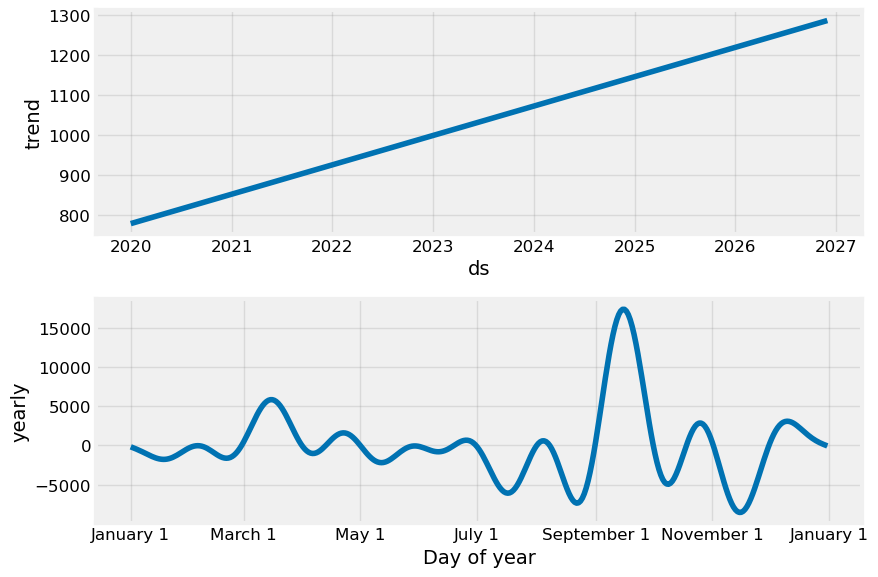

In [43]:
#Day and Year Technology Sales Trend Plot
technology_model.plot_components(technology_forecast);

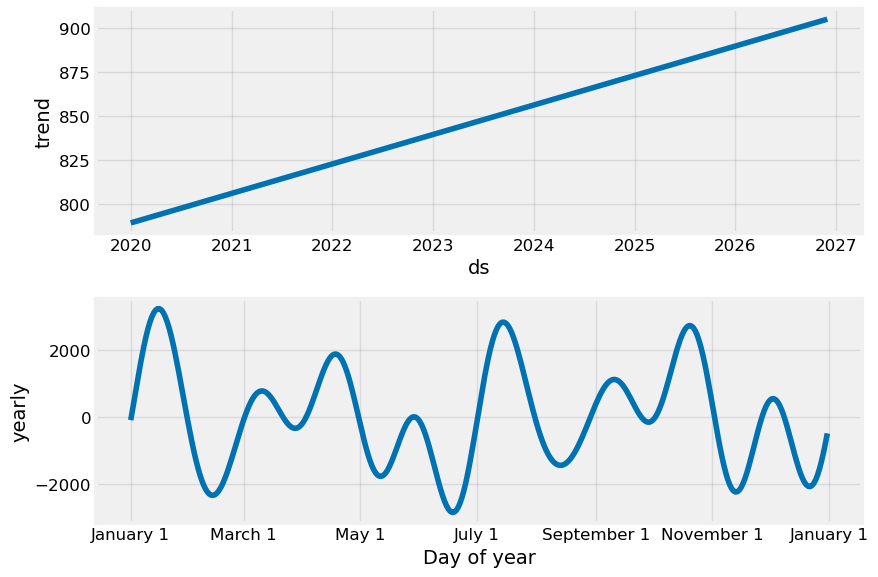

In [44]:
#Day and Year Furniture Sales Trend Plot
furniture_model.plot_components(furniture_forecast);